In [3]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
sns.set()

In [164]:

total_metrics = pd.DataFrame()
for file in glob("results/ResSelNet/*.csv"):
    metrics = pd.read_csv(file)
    total_metrics = pd.concat((total_metrics, metrics)).reset_index(drop=True)

total_metrics["n_features"] = total_metrics.selected_features.str.replace("' '", "','", regex=True).apply(eval).apply(len)

In [165]:
total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT', 'lstm': "LSTM"})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL'})

total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM')  & (total_metrics.selection_params_residual), 'model_name'] = 'TLSTMRes'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM')& (~total_metrics.selection_params_residual.fillna(False)), 'model_name'] = 'TLSTM'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense')& (total_metrics.selection_params_residual), 'model_name'] = 'TFFRes'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense')& (~total_metrics.selection_params_residual.fillna(False)), 'model_name'] = 'TFF'
total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})
total_metrics['dataset'] = total_metrics['dataset'].apply(lambda x: x.capitalize()).replace({'Rondadelvalle': 'Ronda del valle'})
total_metrics.drop("dataset_name", inplace=True, axis=1)

In [166]:
model_params = [col for col in total_metrics.columns if 'model_params' in col or 'selection_params' in col ]
pd.set_option('display.max_columns', 500)

grouped = total_metrics.groupby(['dataset', 'selection_name', 'model_name', *model_params], dropna=False)[["root_mean_squared_error"]].mean()
best_index = grouped.loc[grouped.groupby(['dataset', 'selection_name', 'model_name', 'selection_params_residual'], dropna=False).root_mean_squared_error.idxmin()].index

total_metrics_indexed = total_metrics.set_index(['dataset', 'selection_name', 'model_name',*model_params])

best_by_year = total_metrics_indexed.loc[best_index, ['root_mean_squared_error', 'mean_absolute_error', 'mean_squared_error', 'dataset_params_test_year', 'dataset_params_seq_len', 'dataset_params_crossval', "dataset_params_shift","dataset_params_pred_len", 'features', 'selected_features', 'duration', 'n_features']].reset_index()

best_by_year[(best_by_year.dataset_params_test_year>2005) | (best_by_year.dataset_params_test_year.isna())].groupby(['dataset', 'model_name'], dropna=False)[["root_mean_squared_error", "mean_squared_error", "mean_absolute_error", "duration", 'n_features', 'dataset_params_seq_len']].mean().reset_index().pivot(index = 'dataset', columns='model_name', values=['mean_absolute_error', 'n_features', 'dataset_params_seq_len']).round(1)#[["TFF", "TLSTM"]]#.to_latex()

mean_absolute_error                                    \
model_name                       DT         FF          L1       LSTM   
dataset                                                                 
Aljarafe                       13.4       13.5        13.0       12.9   
Asomadilla                     13.5       13.0        12.6       12.6   
Bermejales                     14.9       14.5        14.0       14.3   
Cif2016o12                  20592.9    13413.6     13386.6    17897.9   
Cif2016o6                 3980280.1  4972109.9  11761123.0  4926662.1   
Demand                       1004.5     1015.9      1467.3      802.1   
Etth1                           1.8        2.5         1.4        1.5   
Etth2                           5.1        4.9         4.0        4.2   
Raif                            2.1        2.0         1.5        1.4   
Raifpicada                      1.7        1.7         1.7        1.7   
Ronda del valle                15.8       14.9        14.8       14.5   
Torneo                         11.6       11.1        10.8       10.8   
Tourism                      6596.8     3930.9      2805.8     7256.6   
Vidjerez                        1.6        1.7         1.7        1.8   
Vidjerezlobes                   0.5        0.4         0.4        0.4   
Wikiwebtraffic                 18.5       16.7        18.8       15.4   

                                                             n_features  \
model_name              TFF     TFFRes      TLSTM   TLSTMRes         DT   
dataset                                                                   
Aljarafe               12.8       12.4       12.5       12.6       20.2   
Asomadilla             12.8       12.3       12.4       12.3        8.8   
Bermejales             13.8       13.7       14.0       13.8       19.5   
Cif2016o12          12982.2     9597.0    15907.5    17507.5       12.0   
Cif2016o6        10648782.9  8671929.0  6335916.0  8694448.5        6.0   
Demand                974.3      837.4      981.9      841.7       70.0   
Etth1                   1.7        1.7        1.4        1.5        8.0   
Etth2                   5.0        4.3        4.4        4.1      227.0   
Raif                    1.2        1.5        1.4        1.4       47.0   
Raifpicada              1.6        1.5        1.6        1.5        7.0   
Ronda del valle        14.2       13.9       14.1       14.0        8.2   
Torneo                 10.9       10.4       10.8       10.4        7.2   
Tourism              4195.4     2806.4     7456.9     4262.3       19.5   
Vidjerez                1.4        1.5        1.4        1.3       27.0   
Vidjerezlobes           0.4        0.6        0.1        0.4        3.0   
Wikiwebtraffic         16.6       17.4       15.5       16.2       77.0   

                                                                    \
model_name          FF     L1   LSTM    TFF TFFRes  TLSTM TLSTMRes   
dataset                                                              
Aljarafe         234.0  218.0  408.0   27.2   29.0  199.6    118.1   
Asomadilla       168.0   63.4  300.0   24.4   20.4   95.8    189.0   
Bermejales       120.0  183.5  340.0   23.0  113.5  161.3    162.4   
Cif2016o12        10.0   12.0   10.0   12.0   11.0    9.0     11.0   
Cif2016o6          5.0    6.0    5.0    1.0    6.0    5.0      6.0   
Demand            53.0   25.0   50.0   13.0   29.0   35.0     59.0   
Etth1            152.0    4.0  228.0   13.0  127.0  168.0    166.0   
Etth2            181.0   17.0  187.0   33.0  104.0  157.0    136.0   
Raif              31.0   50.0   31.0    8.0    5.0    5.0      5.0   
Raifpicada        31.0   50.0   31.0    8.0   15.0    2.0     15.0   
Ronda del valle  138.0   24.5  408.0   25.8   31.9  155.7    222.4   
Torneo            84.0   96.2  300.0  124.4  238.5  155.0    181.7   
Tourism           21.0   25.0   21.0   19.0   17.0   13.0     22.0   
Vidjerez          29.0   38.0   29.0    1.0    2.0    2.0      1.0   
Vidjerezlobe

In [13]:
best_by_year[(best_by_year.dataset_params_test_year>2005) | (best_by_year.dataset_params_test_year.isna())].groupby(['dataset', 'model_name'], dropna=False)[["root_mean_squared_error", "mean_squared_error", "mean_absolute_error", "duration", 'n_features', 'dataset_params_seq_len']].mean().reset_index().pivot(index = 'dataset', columns='model_name', values=["n_features" , "duration"]).round(1).to_excel("results_resselnet_duration4.xlsx")

In [21]:
best_by_year[(best_by_year.dataset_params_test_year>2005) | (best_by_year.dataset_params_test_year.isna())].groupby(['dataset', 'model_name'], dropna=False)[["root_mean_squared_error", "mean_squared_error", "mean_absolute_error", "duration", 'n_features', 'dataset_params_seq_len']].mean().reset_index().pivot(index = 'dataset', columns='model_name', values=["mean_absolute_error", "mean_squared_error", "root_mean_squared_error"]).round(1).to_excel("results_resselnet_error3.xlsx")

In [73]:
model_params = [col for col in total_metrics.columns if 'model_params' in col or 'selection_params' in col]
grouped = total_metrics.groupby(['dataset', 'selection_name', 'model_name', *model_params], dropna=False)[["root_mean_squared_error_valid"]].mean()
best_index = grouped.loc[grouped.groupby(['dataset', 'selection_name', 'model_name', 'selection_params_residual'], dropna=False).root_mean_squared_error_valid.idxmin()].index

total_metrics_indexed = total_metrics.set_index(['dataset', 'selection_name', 'model_name',*model_params])

best_by_year = total_metrics_indexed.loc[best_index, ['root_mean_squared_error', 'mean_absolute_error', 'mean_squared_error', 'dataset_params_test_year', 'dataset_params_seq_len', 'features', 'selected_features', 'duration', 'n_features']].reset_index()

best_by_year[(best_by_year.dataset_params_test_year>2005) | (best_by_year.dataset_params_test_year.isna())].groupby(['dataset', 'model_name'], dropna=False)[["root_mean_squared_error", "mean_squared_error", "mean_absolute_error", "duration", 'n_features']].mean().reset_index().pivot(index = 'dataset', columns='model_name', values=['mean_absolute_error', 'n_features']).round(1)#[["TFF", "TLSTM"]]#.to_latex()

mean_absolute_error                                       \
model_name                       DT      FF      L1   LSTM    TFF TFFRes   
dataset                                                                    
Aljarafe                       13.4    13.5    13.0   12.9   12.8   12.4   
Asomadilla                     13.5    13.3    12.6   12.9   12.7   12.3   
Bermejales                     14.9    14.7    14.0   14.5   13.8   13.9   
Demand                       1196.4  1015.9  1467.3  802.1  974.3  909.3   
Etth1                           2.2     4.0     1.8    1.5    1.9    3.9   
Etth2                           7.7     5.7     4.4    5.0    4.9    6.2   
Ronda del valle                15.8    14.9    14.8   14.5   14.2   13.9   
Torneo                         11.6    11.1    10.8   10.8   10.7   10.4   

                                n_features                                    \
model_name       TLSTM TLSTMRes         DT     FF     L1   LSTM   TFF TFFRes   
dataset                                                                        
Aljarafe          12.7     12.7       20.2  234.0  218.0  402.0  27.2   29.0   
Asomadilla        12.5     12.3        8.8  174.0   63.4  408.0  25.6   20.4   
Bermejales        14.0     13.8       19.5  120.0  183.5  130.0  23.0   62.2   
Demand           954.0    853.0       63.0   53.0   25.0   50.0  13.0   27.0   
Etth1              1.4      3.4       42.5  181.0   41.0  228.0  30.0  296.0   
Etth2              6.0      6.1      291.0  199.0    9.0  228.0  51.0  168.0   
Ronda del valle   14.2     14.0        8.2  138.0   24.5  408.0  25.8   31.9   
Torneo            10.7     10.4        7.2   84.0   96.2  300.0  23.7  238.5   

                                 
model_name       TLSTM TLSTMRes  
dataset                          
Aljarafe         154.2    182.8  
Asomadilla       197.8    189.0  
Bermejales       161.3    162.4  
Demand            31.0     52.0  
Etth1            168.0    113.0  
Etth2            110.0    235.0  
Ronda del valle  221.1    222.4  
Torneo           249.8    181.7

<Figure size 1440x1440 with 0 Axes>

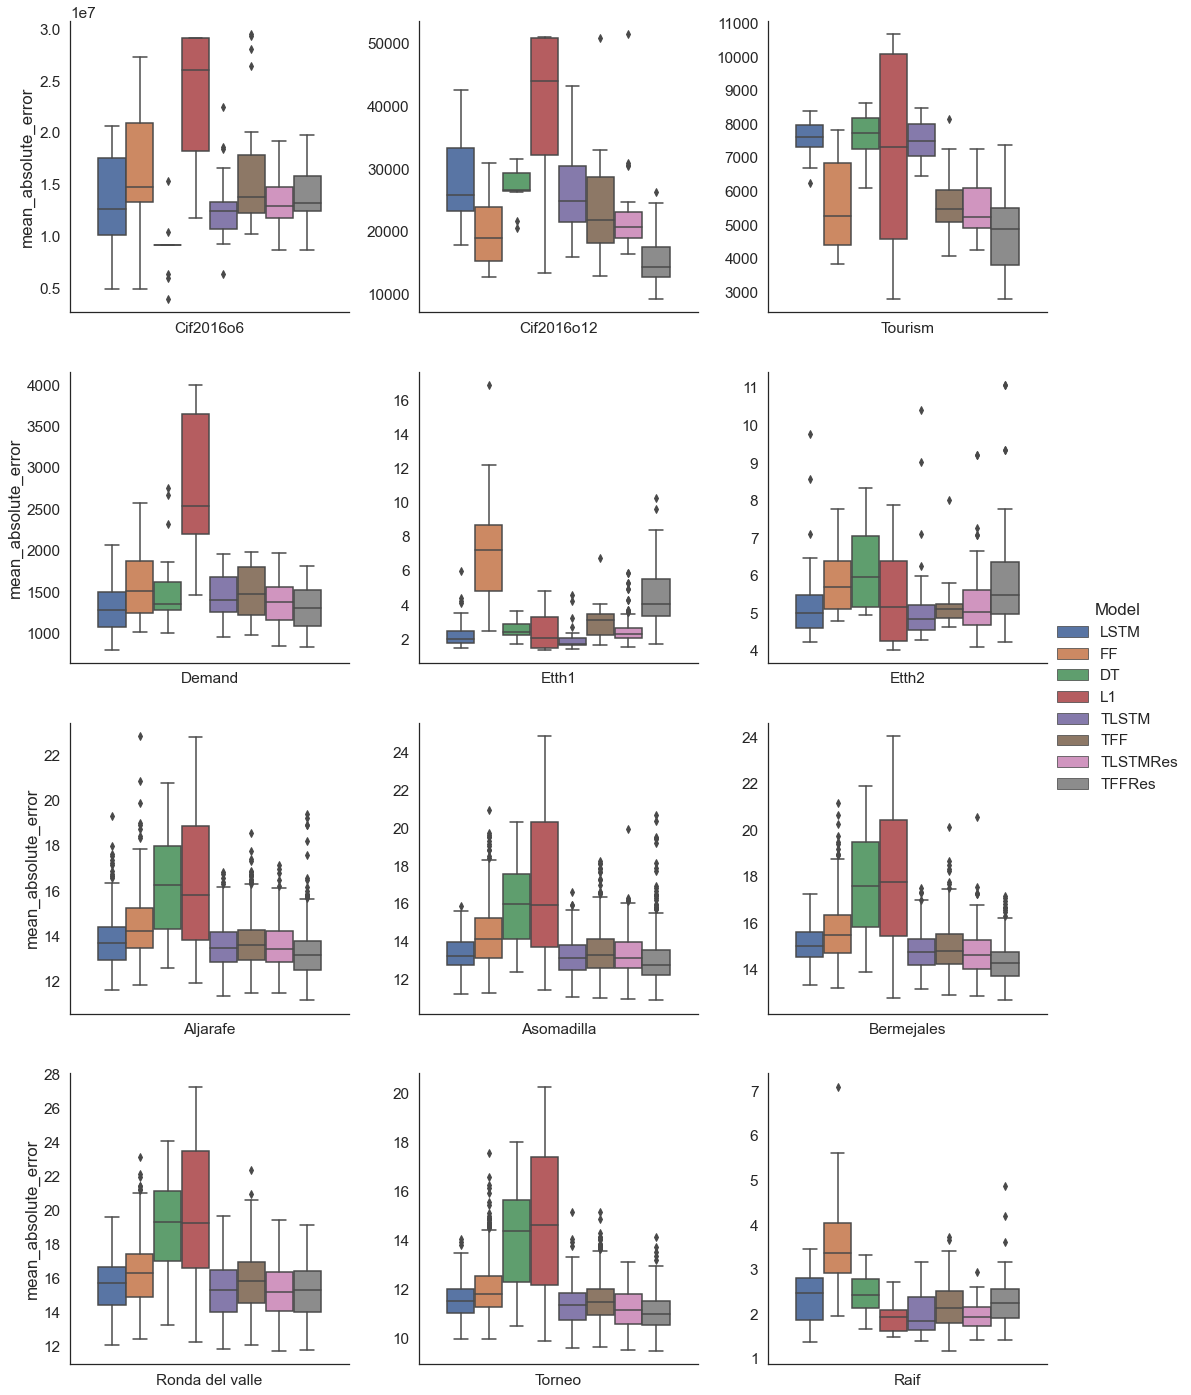

In [14]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics = total_metrics.rename({'model_name': 'Model', 'root_mean_squared_error': 'RMSE', 'n_features': '# Features'}, axis=1)
g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="mean_absolute_error", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 1440x1440 with 0 Axes>

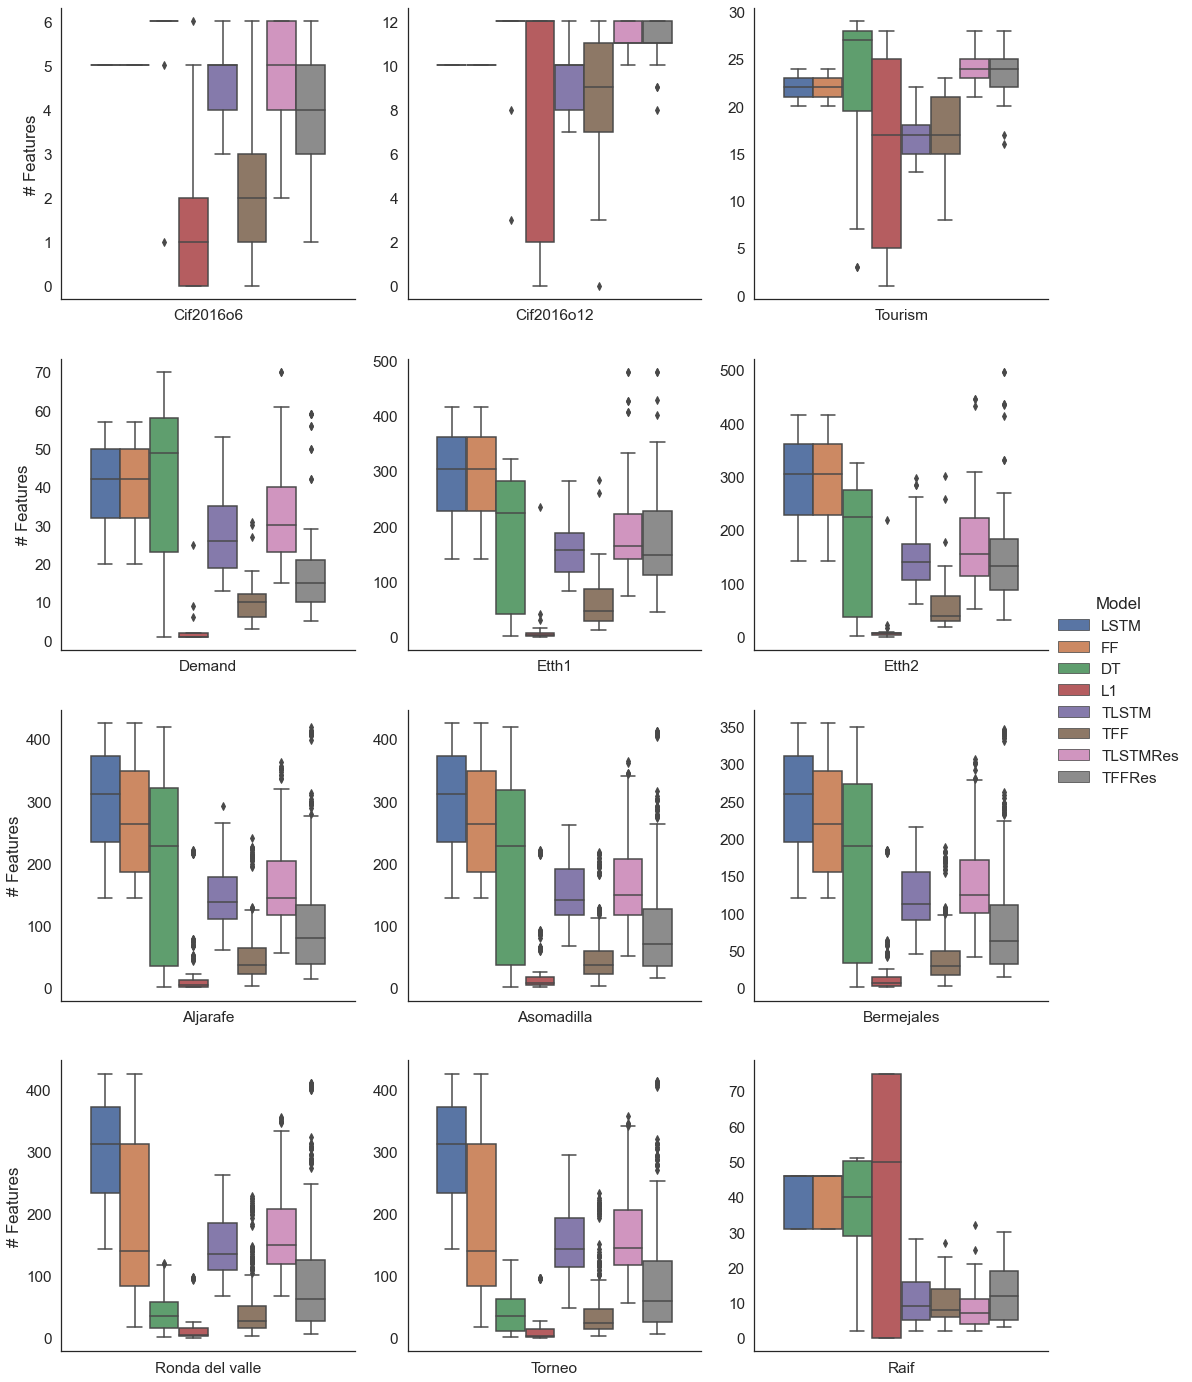

In [16]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)

g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
#plt.savefig('figures/boxplot_Features.png')
plt.show()
plt.show()

## Selection masks

0.359375
0.4948717948717949
0.48
0.4812206572769953
0.57981220657277


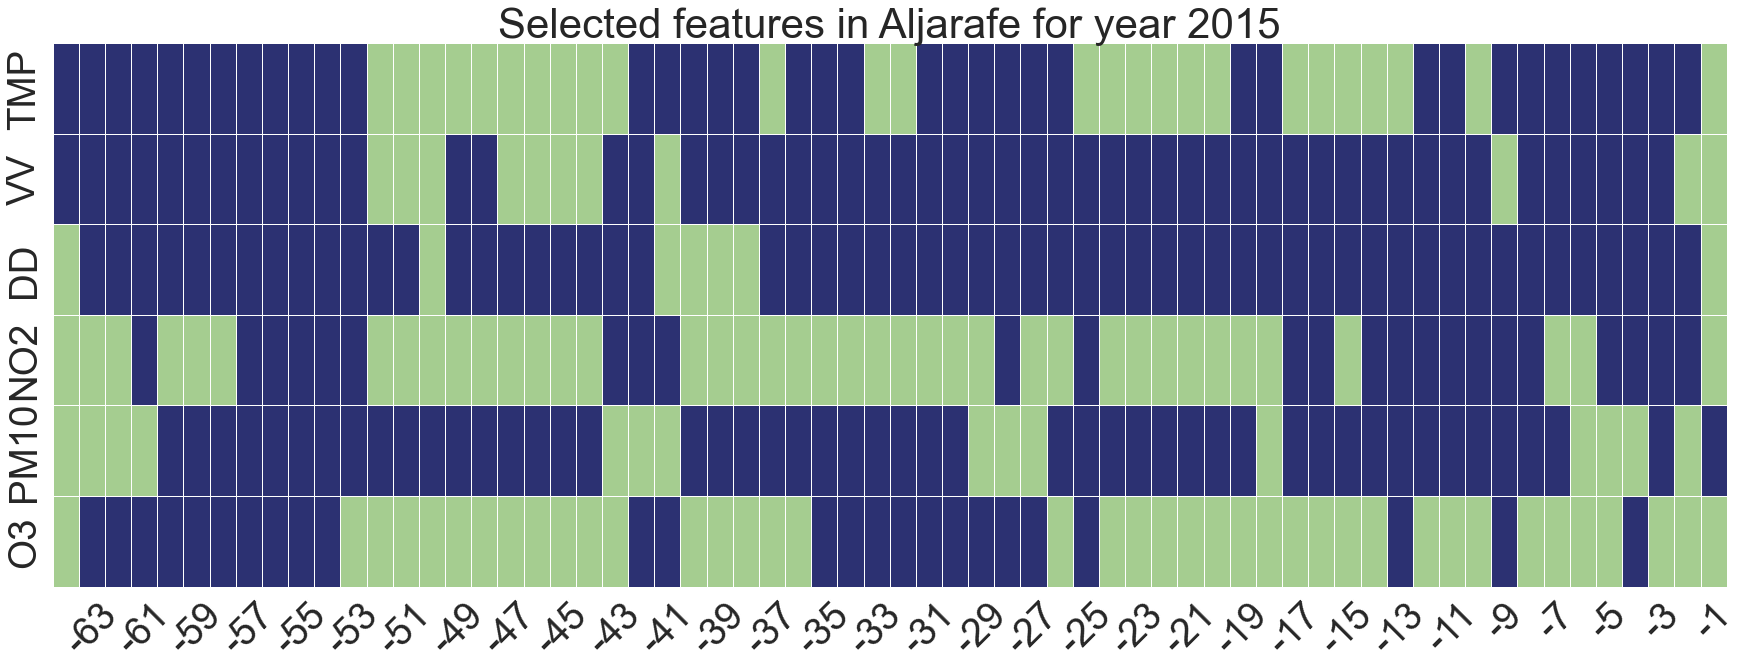

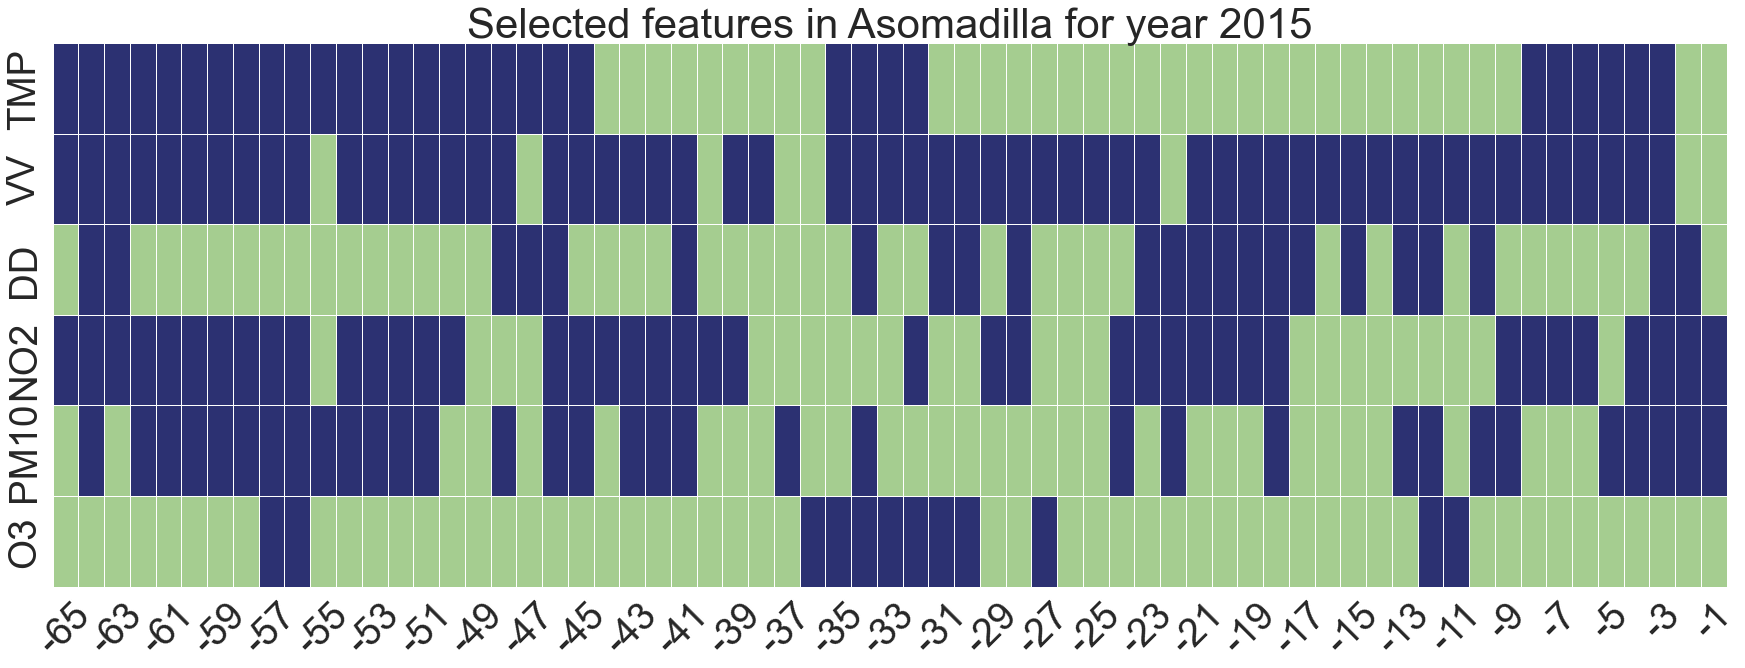

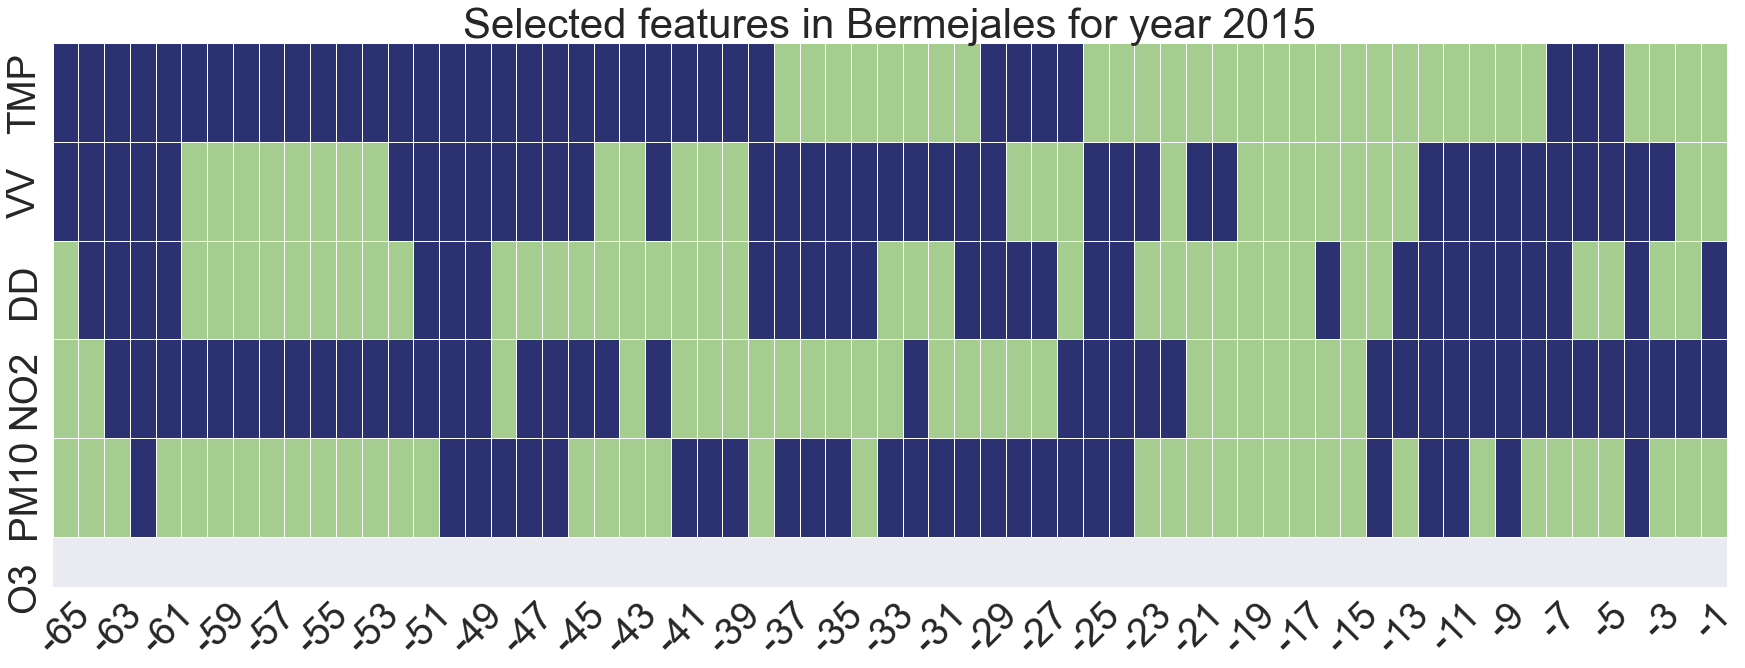

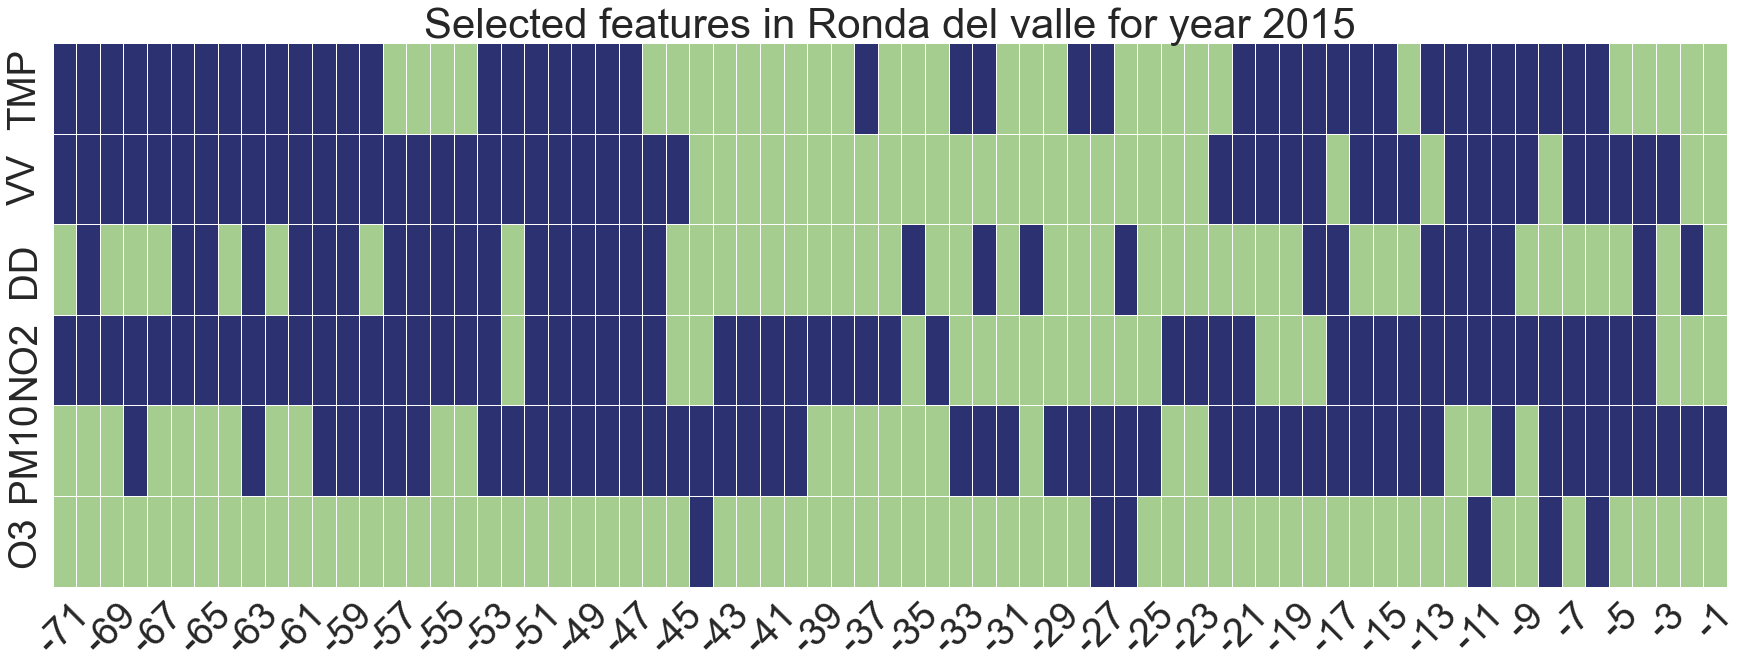

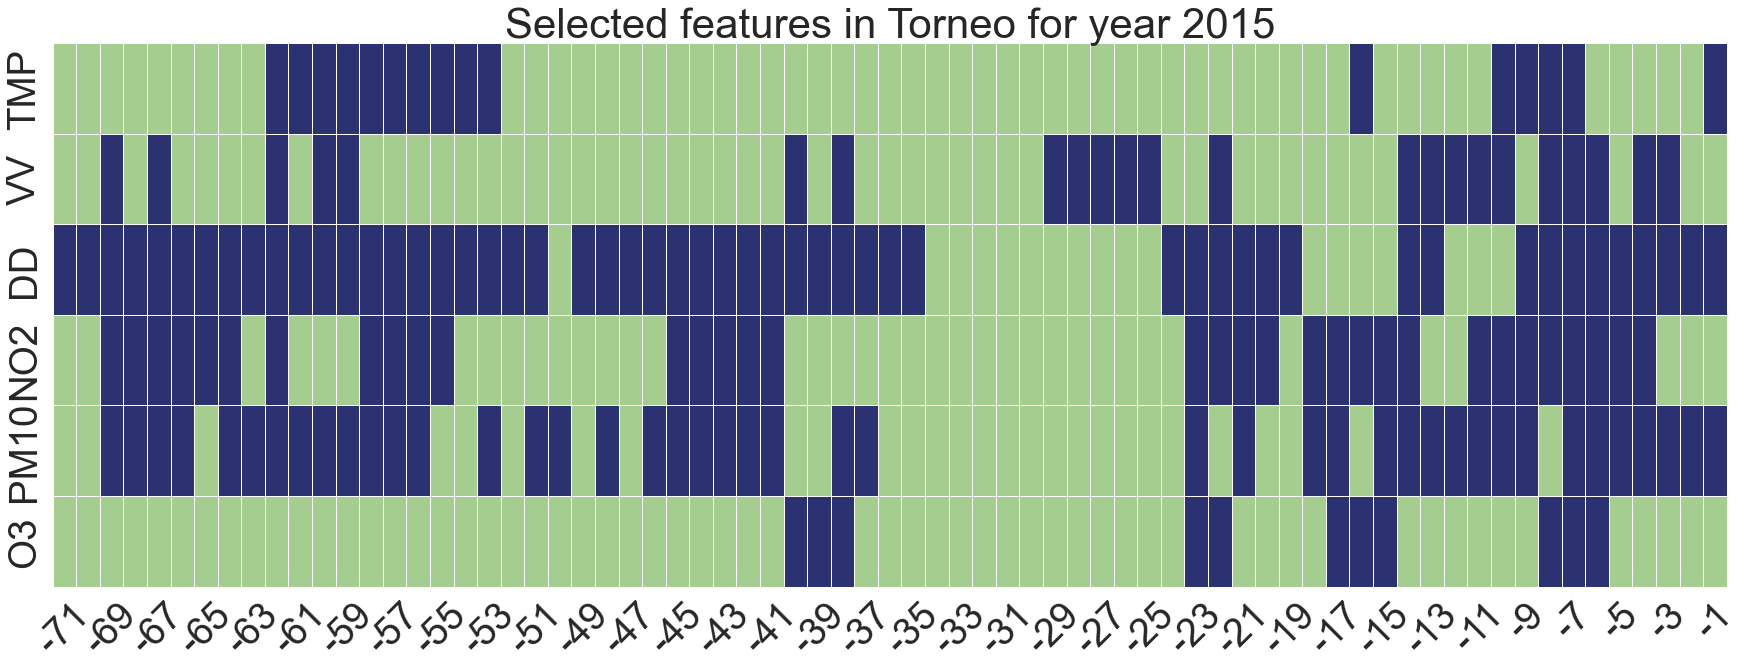

In [7]:
sns.set(font_scale=3.5)
best_by_year_selected = best_by_year[best_by_year.dataset_params_test_year>2005]

fetures_list = []#['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_by_year_selected.dataset.unique():
    results_tsl_dataset = best_by_year_selected[(best_by_year_selected.dataset==dataset) & (best_by_year_selected.model_name=='TLSTM')].sort_values('dataset_params_test_year')
    results_tsl_dataset1 = best_by_year_selected[best_by_year_selected['dataset_params_test_year']==2015]
    features = results_tsl_dataset.features.apply(eval).apply(np.array).values[0]
    selected_features = results_tsl_dataset.selected_features.apply(eval).apply(np.array).values[0]

    selection_masks = []
    for feat in fetures_list:
        
        feats = features[np.core.defchararray.find(features, feat)!=-1]
        if len(feats)==0:
            continue
        sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

        
        mask = np.isin(feats, sfeats).astype(np.uint)
        selection_masks.append(mask)
    
    selection_masks = np.stack(selection_masks)
    print(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]))
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_title(f'Selected features in {dataset} for year 2015')
    cmap = sns.cm.crest_r
    feats[-2::-2] = ''
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), fetures_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), cbar=False, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)
    fig = g.get_figure()
    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

## Bayesian tests

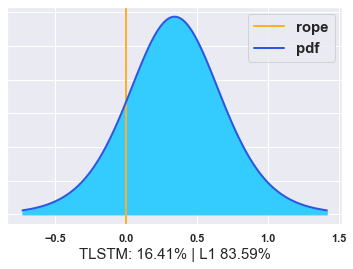

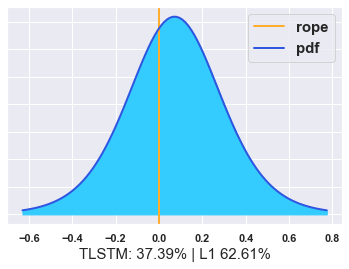

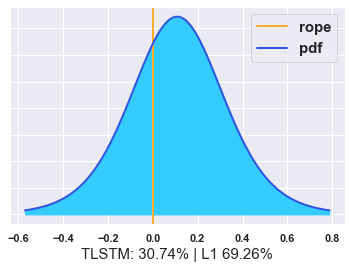

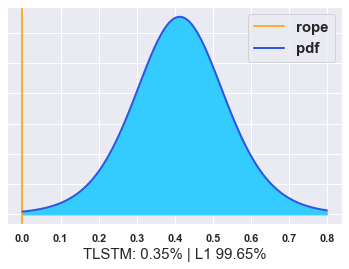

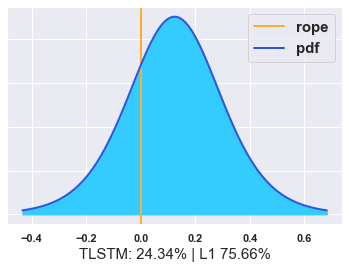

In [36]:
from baycomp import two_on_single
import matplotlib

import matplotlib.pyplot as plt



for dataset in best_metrics.dataset.unique():
    metrics_tsl = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='TLSTM')].root_mean_squared_error.values
    metrics_l1 = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='L1')].root_mean_squared_error.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, names=['TLSTM', 'L1'], plot=True)
    plt.xlabel(f'TLSTM: {round(probs[0]*100, 2)}% | L1 {round(probs[1]*100, 2)}%', fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png") 

## Best hyperparameters

In [167]:
best_hyperparameters = best_by_year.reset_index().groupby(['dataset', 'model_name']).head(1).reset_index()

In [168]:
import numpy as np
pd.set_option('display.max_colwidth', 2000)
params = list(map(lambda my_dict: {k: my_dict[k] if not my_dict[k].is_integer() else int(my_dict[k]) for k in my_dict if not np.isnan(my_dict[k])},best_index.to_frame()[best_index.to_frame().model_name!='TSLRes'].loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout',  'model_params_max_depth', 'model_params_regularization','selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = best_hyperparameters.dataset_params_seq_len #
best_hyperparameters['params'] = params

best_hyperparameters[["dataset", "model_name", "window", "params", "dataset_params_seq_len"]].set_index(['dataset', 'model_name', 'window'])#.iloc[-60:]#[best_hyperparameters.model_name=="TSL+LSTM"].set_index(['dataset']).to_dict('index')#.to_latex('tab.tex')

params  \
dataset        model_name window                                                                                                                                                                                                                                  
Aljarafe       DT         45                                                                                                                                                                                                      {'model_params_max_depth': 5}   
               FF         39                                                            {'model_params_layers': 1, 'model_params_units': 35, 'model_params_batch_size': 117, 'model_params_lr': 0.0062097346448451, 'model_params_dropout': 0.2868397433361429}   
               L1         38                                                                                                                                                                                {'model_params_regularization': 0.0001143748173448}   
               LSTM       68                                                             {'model_params_layers': 1, 'model_params_units': 24, 'model_params_batch_size': 31, 'model_params_lr': 0.0017370065514576, 'model_params_dropout': 0.4036956443547619}   
               TFF        41                                                                             {'model_params_layers': 2, 'model_params_units': 47, 'model_params_dropout': 0.163322450886048, 'selection_params_regularization': 0.0088594323988978}   
...                                                                                                                                                                                                                                                         ...   
Wikiwebtraffic LSTM       62                                                             {'model_params_layers': 2, 'model_params_units': 36, 'model_params_batch_size': 27, 'model_params_lr': 0.0042003747683163, 'model_params_dropout': 0.2070279939097841}   
               TFF        84       {'model_params_layers': 2, 'model_params_units': 45, 'model_params_batch_size': 80, 'model_params_lr': 0.0070276077642072, 'model_params_dropout': 0.073364287452905, 'selection_params_regularization': 0.0010234340548353}   
               TFFRes     70      {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 85, 'model_params_lr': 0.0069398794834175, 'model_params_dropout': 0.0079106214232781, 'selection_params_regularization': 0.0099732287722297}   
               TLSTM      70      {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 85, 'model_params_lr': 0.0069398794834175, 'model_params_dropout': 0.0079106214232781, 'selection_params_regularization': 0.0099732287722297}   
               TLSTMRes   82       {'model_params_layers': 1, 'model_params_units': 37, 'model_params_batch_size': 83, 'model_params_lr': 0.0098872999286832, 'model_params_dropout': 0.2844257185432406, 'selection_params_regularization': 0.005797494217936}   

                                  dataset_params_seq_len  
dataset        model_name window                          
Aljarafe       DT         45                          45  
               FF         39                          39  
               L1         38                          38  
               LSTM       68                          68  
               TFF        41                          41  
...                                                  ...  
Wikiwebtraffic LSTM       62                          62  
               TFF        84                          84  
               TFFRes     70                          70  
               TLSTM      70                          70  
               TLSTMRes   82                          82  

[128 rows x 2 columns]

In [170]:
best_hyperparameters.to_csv("results/ResSelNet/params/best_params.csv")